# dot calculation

By utilizing the structure of the Amat, we can compute the vector matrix product in a more efficient way.

In this notebook, we will check the faster way actually works and compare the performance with the naive way.


In [6]:
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from exputils.Amat.get import get_Amat
from exputils.dot.calc_dot import calc_dot
from exputils.dot.get_topK_Amat import get_topK_Amat
from exputils.stabilizer_group import total_stabilizer_group_size
from exputils.state.random_ket import make_random_quantum_state

In [7]:
from exputils.math.q_binom import q_binomial


n = 10
total = 0
for k in range(10 + 1):
    if k == 0:
        term = 1 << k
    else:
        term = q_binomial(n, k) * (1 << (n + k * (k + 1) // 2))
    total += term
    print(f"{k:>2}, {term:>20}, {total:>20}")

 0,                    1,                    1
 1,              2095104,              2095105
 2,           1427464192,           1429559297
 3,         416003850240,         417433409537
 4,       56354654912512,       56772088322049
 5,     3664870461407232,     3721642549729281
 6,   115414333260824576,   119135975810553857
 7,  1744846613077032960,  1863982588887586817
 8, 12261824041702129664, 14125806630589716481
 9, 36857459350400139264, 50983265980989855745
10, 36893488147419103232, 87876754128408958977


n=3
[k|progress|range]: 1 |  120/1080 | [0.01721, 0.87813] | 48[ms]
[k|progress|range]: 2 |  568/1080 | [0.12545, 0.87813] | 48[ms]
[k|progress|range]: 3 | 1080/1080 | [0.32772, 0.87813] | 48[ms]
 calculation time : 48[ms]
branch cut / total: 0/1080
t1-t0=0.0014938999665901065
t2-t1=0.003972699982114136
t3-t2=0.10064310010056943
Counter({8: 248, 4: 204, 2: 46, 1: 2})


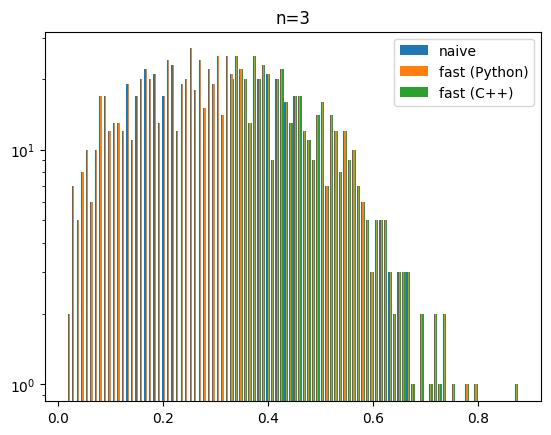

n=4
[k|progress|range]: 1 |   496/36720 | [0.00646, 0.58428] | 1[ms]
[k|progress|range]: 2 |  4976/36720 | [0.37852, 0.66150] | 1[ms]
[k|progress|range]: 3 | 20336/36720 | [0.46664, 0.69257] | 2[ms]
[k|progress|range]: 4 | 36720/36720 | [0.49941, 0.69257] | 2[ms]
 calculation time : 2[ms]
branch cut / total: 0/36720
t1-t0=0.0010232999920845032
t2-t1=0.034629899892024696
t3-t2=0.04193260008469224
Counter({16: 239, 8: 206, 4: 50, 2: 5})


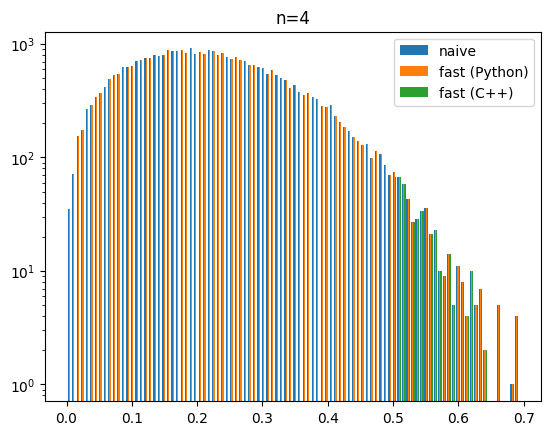

n=5
[k|progress|range]: 1 |    2016/2423520 | [0.21338, 0.39928] | 1[ms]
[k|progress|range]: 2 |   41696/2423520 | [0.35321, 0.49106] | 2[ms]
[k|progress|range]: 3 |  359136/2423520 | [0.42812, 0.57949] | 4[ms]
[k|progress|range]: 4 | 1374944/2423520 | [0.47003, 0.59642] | 7[ms]
[k|progress|range]: 5 | 2423520/2423520 | [0.49014, 0.59912] | 14[ms]
 calculation time : 14[ms]
branch cut / total: 1277440/2423520
t1-t0=0.06809219997376204
t2-t1=2.3765256000915542
t3-t2=0.05840219999663532
Counter({32: 271, 16: 198, 8: 30, 4: 1})


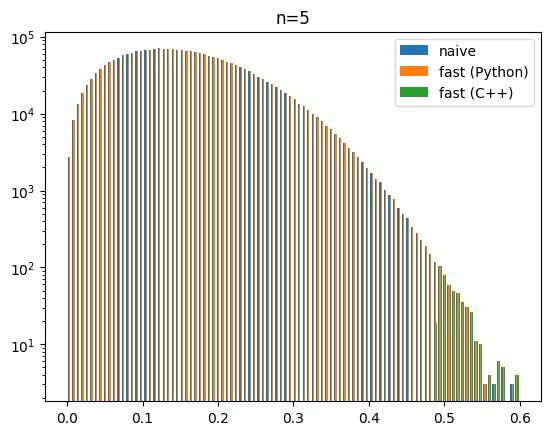

In [8]:
for n in [3, 4, 5]:
    print(f"{n=}")

    random.seed(0)
    psi = make_random_quantum_state("pure", n, seed=0)

    Amat = get_Amat(n)
    t0 = time.perf_counter()
    ansSlow = np.array(psi).conj() @ Amat
    t1 = time.perf_counter()
    ansFast = calc_dot(n, psi.tolist())
    t2 = time.perf_counter()
    states = get_topK_Amat(n, psi, is_dual_mode=False)
    ansFast2 = np.abs(psi.conjugate() @ states)
    t3 = time.perf_counter()
    print(f"{t1-t0=}")
    print(f"{t2-t1=}")
    print(f"{t3-t2=}")
    print(Counter(np.count_nonzero(states.toarray(), axis=0)))

    plt.hist([np.abs(ansSlow), np.abs(ansFast), np.abs(ansFast2)], bins=100)
    plt.title(f"n={n}")
    plt.legend(["naive", "fast (Python)", "fast (C++)"])
    plt.yscale("log")
    plt.show()

    assert len(ansSlow) == len(ansFast)
    assert np.allclose(np.sort(ansSlow), np.sort(ansFast))
    # if n <= 4:
    #     assert np.allclose(np.sort(np.abs(ansSlow)), np.sort(np.abs(ansFast2)))

    # if n <= 2:
    #     mat = np.zeros((2, len(ansSlow)), dtype=np.complex128)
    #     for i in range(len(ansSlow)):
    #         mat[0, i] = ansSlow[i]
    #         mat[1, i] = ansFast[i]
    #     vis_matrix(mat)

    # assert np.allclose(np.sort(ansSlow), np.sort(ansFast))

    # cnt = 3 if n == 1 else 30
    # col_idxs = np.argpartition(np.abs(ansFast), -cnt)[-cnt:]
    # dots_abs_ans = np.abs(ansFast[col_idxs])
    # dots_abs_check = []
    # states = recovery_states_from_idxs(n, col_idxs)
    # for state in states:
    #     dots_abs_check.append(abs(state @ psi))
    # dots_abs_check = np.array(dots_abs_check)
    # print(f"{dots_abs_ans=}")
    # print(f"{dots_abs_check=}")
    # assert np.allclose(np.sort(dots_abs_ans), np.sort(dots_abs_check))

n=6 total_stabilizer_group_size(n)=315057600
psi[:10]=array([ 0.00191592-0.055118j  ,  0.05823157+0.03303339j,
       -0.0873583 -0.00839837j, -0.042261  -0.06658054j,
       -0.04508918-0.03069197j, -0.05638643-0.08410659j,
        0.0249202 +0.0817603j , -0.03569263-0.11142187j,
        0.14494395-0.06691227j, -0.09171176+0.03051833j])
[k|progress|range]: 1 |      8128/315057600 | [0.21527, 0.36886] | 1[ms]
[k|progress|range]: 2 |    341440/315057600 | [0.32339, 0.44131] | 5[ms]
[k|progress|range]: 3 |   6055360/315057600 | [0.38147, 0.47986] | 16[ms]
[k|progress|range]: 4 |  48719296/315057600 | [0.41384, 0.48983] | 38[ms]
[k|progress|range]: 5 | 180839872/315057600 | [0.43104, 0.53119] | 76[ms]
[k|progress|range]: 6 | 315057600/315057600 | [0.43889, 0.53119] | 252[ms]
 calculation time : 252[ms]
branch cut / total: 305478656/315057600
t1-t0=0.3182242000475526
Counter({32: 201, 64: 199, 16: 86, 8: 13, 4: 1})


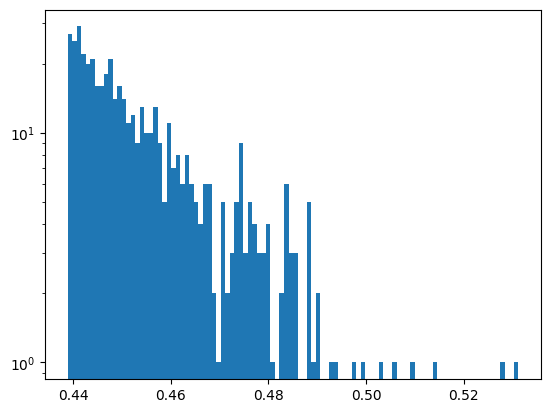

n=7 total_stabilizer_group_size(n)=81284860800
psi[:10]=array([ 0.07913827+0.06814959j,  0.00593093+0.01811256j,
        0.05109879-0.00323261j,  0.02199331-0.00808749j,
       -0.08410508-0.00334621j,  0.05044391-0.01531157j,
       -0.05669442+0.08172552j, -0.01057939-0.05585817j,
        0.14989151-0.01841798j, -0.10853592+0.06166335j])
[k|progress|range]: 1 |       32640/81284860800 | [0.18289, 0.30373] | 2[ms]
[k|progress|range]: 2 |     2763648/81284860800 | [0.25948, 0.34968] | 25[ms]
[k|progress|range]: 3 |    99519360/81284860800 | [0.30516, 0.37190] | 98[ms]
[k|progress|range]: 4 |  1647610752/81284860800 | [0.33597, 0.41110] | 318[ms]
[k|progress|range]: 5 | 12833819520/81284860800 | [0.35760, 0.41110] | 960[ms]
[k|progress|range]: 6 | 46925122432/81284860800 | [0.36926, 0.41908] | 2342[ms]
[k|progress|range]: 7 | 81284860800/81284860800 | [0.37364, 0.41908] | 3278[ms]
 calculation time : 3278[ms]
branch cut / total: 81228433408/81284860800
t1-t0=3.4903815999859944
Counter({

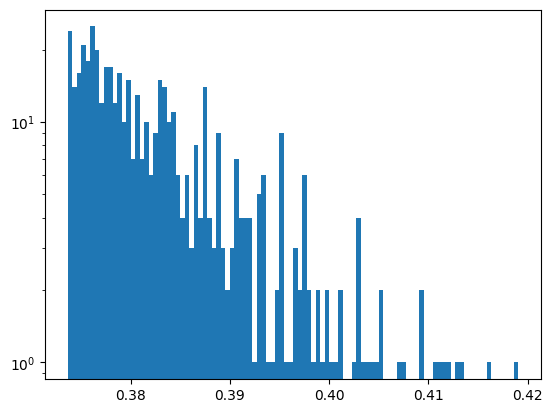

n=8 total_stabilizer_group_size(n)=41780418451200
psi[:10]=array([-0.02468419-0.01300555j, -0.04743796-0.01841991j,
       -0.04517999+0.00046806j, -0.03190195-0.05473635j,
        0.03236416-0.00138037j,  0.00424968-0.07011695j,
        0.0580995 -0.01847172j,  0.07891767-0.06241548j,
        0.08388194+0.01988365j,  0.03656884+0.02063767j])
[k|progress|range]: 1 |         130816/41780418451200 | [0.15226, 0.20786] | 6[ms]
[k|progress|range]: 2 |       22238976/41780418451200 | [0.21125, 0.26887] | 199[ms]
[k|progress|range]: 3 |     1614026496/41780418451200 | [0.24705, 0.29796] | 921[ms]
[k|progress|range]: 4 |    54249133824/41780418451200 | [0.27162, 0.31185] | 2826[ms]
[k|progress|range]: 5 |   869244344064/41780418451200 | [0.28729, 0.32884] | 16237[ms]
[k|progress|range]: 6 |  6664765839104/41780418451200 | [0.29875, 0.33431] | 82438[ms]
[k|progress|range]: 7 | 24188232406784/41780418451200 | [0.30411, 0.33431] | 261667[ms]
[k|progress|range]: 8 | 41780418451200/41780418451200 

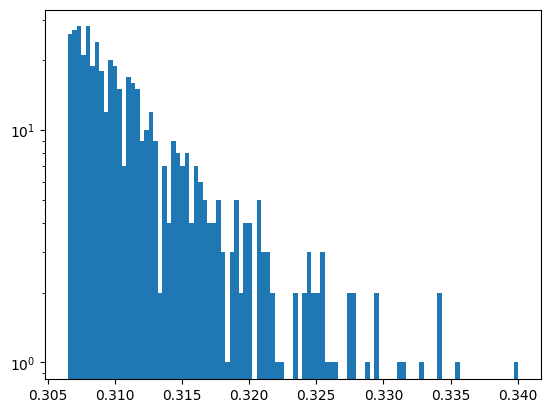

In [9]:
for n in [6, 7, 8]:
    print(f"{n=} {total_stabilizer_group_size(n)=}")

    random.seed(0)
    psi = make_random_quantum_state("pure", n, seed=0)
    print(f"{psi[:10]=}")

    t0 = time.perf_counter()
    states = get_topK_Amat(n, psi, is_dual_mode=False)
    ans = np.abs(psi.conj().T @ states)
    t1 = time.perf_counter()
    print(f"{t1-t0=}")
    print(Counter(np.count_nonzero(states.toarray(), axis=0)))

    if n <= 5:
        ansSlow = np.abs(calc_dot(n, psi.tolist()))
        plt.hist([ans, ansSlow], bins=100)
    else:
        plt.hist(ans, bins=100)
    plt.yscale("log")
    plt.show()